# Stephen King Novel NLP

## Imports

In [3]:
import pandas as pd
import numpy as np
from IPython import display
from pymongo import MongoClient
import os
import re
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from sklearn.decomposition import NMF, LatentDirichletAllocation
from nltk.util import ngrams
import operator
from gensim import corpora, models, similarities, matutils
from sklearn import datasets
import json
import spacy 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.externals import joblib
from afinn import Afinn
import random
import scipy
from scipy.signal import spectrogram
from importlib import reload
from scipy.fftpack import fft
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.interpolate import interp1d


# gensim
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaModel

# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


display.clear_output(wait=True)
from config import user_name,password,ip
from epub_conversion.utils import open_book

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt, mpld3
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 20, 10

## Stoplist

In [4]:
stoplist = stopwords.words('english')
stoplist += ['.', ',', '(', ')', "'", '"']
#stoplist = set(stoplist)

## Import Sentiment

In [5]:
sentDF = pd.read_pickle('sentiment.pkl')

## Functions

### Manual Word Count

In [6]:
def clean_text(row):
    text = row['content'].lower()
    text = text.strip('\n')
    return text

### Manual Word Count

In [7]:
def book_word_count(book,n,stoplist=stoplist):
    text = clean_text(book)
    words = [''.join(words) for words in text.split()]
    title = book['title']
    counter = Counter()
    n = n
    words = [w for w in words if w not in stoplist]
    bigrams = ngrams(words, n)
    counter += Counter(bigrams)
    sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
    return title, sorted_counter

### Count Vectorizer Function

In [8]:
def book_cv(dtbooks,stoplist):
    cv = CountVectorizer(stop_words=stoplist,token_pattern="\\b[a-z][a-z]+\\b")
    print(type(dtbooks[0]))
    cv.fit(dtbooks)
    x = cv.transform(dtbooks)
    x_back = x.toarray()
    df = pd.DataFrame(x_back, columns=cv.get_feature_names())
    counts = cv.transform(dtbooks).transpose()
    print(counts.shape)
    corpus = matutils.Sparse2Corpus(counts)
    id2word = dict((v, k) for k, v in cv.vocabulary_.items())
    return df,corpus,id2word

### Display Topics

In [9]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

### Return Topics

In [10]:
def return_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        words = " ".join([feature_names[i]for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(words)
        top_words = {'topic_idx':topic_idx,'words':words}
        topics.append(top_words)
    
    return topics

### Cleanup

In [11]:
def cleanup(token, lower = True):
    if lower:
       token = token.lower()
    return token.strip()

### Entity Detection

In [12]:
def ie_preprocess(document):
    document = ' '.join([i for i in document.split() if i not in stoplist])
    sentences = nltk.sent_tokenize(document)
    sentences = [nltk.word_tokenize(sent) for sent in sentences]
    sentences = [nltk.pos_tag(sent) for sent in sentences]
    return sentences

In [13]:
def extract_names(document):
    names = []
    sentences = ie_preprocess(document)
    for tagged_sentence in sentences:
        for chunk in nltk.ne_chunk(tagged_sentence):
            if type(chunk) == nltk.tree.Tree:
                if chunk.label() == 'PERSON':
                    names.append(' '.join([c[0] for c in chunk]))
    return names

### Tokenize and Stem

In [14]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

In [15]:
def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

### Sentiment

In [16]:
def a_sentiment(filename):
    with open (filename, "r") as myfile:
        text=myfile.read().replace('\n', ' ')
        blob = TextBlob(text)       
        tot = 0.0
        sent = []        
        afinn = Afinn()
        for sentence in blob.sentences:            
            senti = afinn.score(str(sentence))        
            sent.append(senti)   
        return sent

### Sentiment Plot

In [17]:
def sentiplot(filename, title):
    fig = plt.figure()
    sent= a_sentiment(filename)    
    plt.plot(sent,label=title)
    plt.ylabel("Cumulative Emotional Valence")
    plt.xlabel("Sentence #")    
    plt.legend()


### Plot Stories

In [18]:
def plot_story(title,df=sentDF,f=.1,d=0.0):
    bookDF = df.loc[df['title'] == title]
    sentiment = list(bookDF.sentiment)
    lowX = list(range(1,len(sentiment)+1))
    #print(len(sent),len(lowX))
    low_plot = lowess(sentiment,lowX,frac=.1,return_sorted=False,delta=d)
    #f2 = interp1d(lowX, sentiment, kind='cubic')
    title = title
    #y = np.arange(-1.0,2.0,.1)
    fig = plt.figure()
    plt.plot(low_plot,label=title)
    plt.ylabel("Sentiment Score")
    plt.xlabel("Sentence #")    
    plt.legend()
    plt.savefig('images/'+title+'.svg')
   
    #mpld3.show()
    return

## Data Processing

**Create a dictionary from all books**

In [ ]:
# book_list = []
# book_dict = {}
# path = "/Users/xavier/dev/metis/fletcher/books/"
# for file in os.listdir(path):
#     if file.endswith(".txt"):
#         clean_name = file.replace(" - Stephen King.txt","")
#         book_dict[clean_name] = open(path+file, "r").read()
#         book_list.append(clean_name)

In [17]:
# # Insert the books into mongo db
# clean_list = []
# for k,v in book_dict.items():
#     try:
#         year = re.search("[Cc]opyright ©\s*.*_*(\d{4}).*Stephen King|[Cc]opyright ©\s.*Stephen King.*_*(\d{4})|[Cc]opyright ©\s*.*_*(\d{4}).*Richard Bachman|[Cc]opyright ©\s.*Richard Bachman.*_*(\d{4})",v).group(0) # get copyright year from book text
#         year = re.search("(\d{4})",year).group(0)
#     except:
#         year = ""
#     try:
#         isbn = re.search(".*ISBN+:*(\d*.*)",v)[1].split(" ")
#         isbn = max(isbn, key=len)
#     except:
#         isbn = ""
#     try:
#         start = v.find('******start_of_file******')+25
#         end = v.find('******end_of_file******')
#         text = v[start:end]
#     except:
#         text = ""
        
#     doc = {"title":k,"year":year,'isbn':isbn,"content":text}
#     clean_list.append(doc)
#     #print(doc['title'],doc['isbn'])
#     #print(doc['title'],doc['year'])
#     #db.books.insert_one(doc)

In [18]:
# len(clean_list)

In [19]:
# #pd.DataFrame(a, index=['i',])
# df = pd.DataFrame(clean_list)

In [20]:
# df.to_pickle('books.pkl')

### Import Pickle

In [32]:
df = pd.read_pickle('books.pkl')

In [33]:
df.columns.tolist()

['content', 'isbn', 'title', 'year']

In [34]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


In [35]:
document = df.iloc[28]['content']

In [36]:
# df['content'] = df.content.apply(lambda x: x.lower())
# df['content'] = df.content.apply(lambda x: x.strip("\n"))

In [37]:
# words = [''.join(words) for words in gs_text.split()]
# vectorizer = TfidfVectorizer(stop_words=stop, ngram_range=(1))
# doc_vectors = vectorizer.fit_transform(documents)

### Character extraction test

In [38]:
characters = extract_names(document)

In [39]:
characters

['Penguin Book',
 'Stephen King',
 'Penguin Putnam',
 'Penguin Books',
 'Penguin Putnam',
 'Penguin Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine Pet Sematary Cycle Werewolf',
 'Peter Straub',
 'Dolores Claiborne Insomnia Rose Madder',
 'Wizard Glass Bag Bones',
 'Tom Gordon Dreamcatcher Black House',
 'Peter Straub',
 'Skeleton Crew',
 'Atlantis Everything',
 'Eventual SCREENPLAYS Creepshow Cat',
 'Eye Silver Bullet Maximum Overdrive Pet Sematary Golden',
 'Century',
 'Who',
 'Merrys Pippins',
 'Max Yasgur',
 'Great Woodstock Music Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen Donaldson',
 'Terry Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky Dick Nixon',
 'Mr. Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob Seger',
 'Patrol Boy',
 'Bad Lieutenant',
 'Patrol Boy',
 'Mine',
 'Stephen',
 'God',
 'Tolkien',
 'Pall Malls',
 'Patrol Boy',
 'Maine',
 'Sergio Leone',
 'Bad',
 'Ugly',
 'Tolkien',
 'Leone',
 'Clint',
 'Lee Van Cleef',
 'Wizard Glass',
 'Leone',
 'Phoenix',
 'Seems',
 'Patr

In [40]:
characters = [s.split(" ") for s in characters]

In [41]:
flat_list = [item for sublist in characters for item in sublist]

In [42]:
flat_list

['Penguin',
 'Book',
 'Stephen',
 'King',
 'Penguin',
 'Putnam',
 'Penguin',
 'Books',
 'Penguin',
 'Putnam',
 'Penguin',
 'Putnam',
 'STEPHEN',
 'Carrie',
 'Salem',
 'Christine',
 'Pet',
 'Sematary',
 'Cycle',
 'Werewolf',
 'Peter',
 'Straub',
 'Dolores',
 'Claiborne',
 'Insomnia',
 'Rose',
 'Madder',
 'Wizard',
 'Glass',
 'Bag',
 'Bones',
 'Tom',
 'Gordon',
 'Dreamcatcher',
 'Black',
 'House',
 'Peter',
 'Straub',
 'Skeleton',
 'Crew',
 'Atlantis',
 'Everything',
 'Eventual',
 'SCREENPLAYS',
 'Creepshow',
 'Cat',
 'Eye',
 'Silver',
 'Bullet',
 'Maximum',
 'Overdrive',
 'Pet',
 'Sematary',
 'Golden',
 'Century',
 'Who',
 'Merrys',
 'Pippins',
 'Max',
 'Yasgur',
 'Great',
 'Woodstock',
 'Music',
 'Festival',
 'Gandalfs',
 'Tolkien',
 'Stephen',
 'Donaldson',
 'Terry',
 'Brooks',
 'Tolkien',
 'Tolkien',
 'Tricky',
 'Dick',
 'Nixon',
 'Mr.',
 'Tolkien',
 'Look',
 'Stevie',
 'Nineteen',
 'Bob',
 'Seger',
 'Patrol',
 'Boy',
 'Bad',
 'Lieutenant',
 'Patrol',
 'Boy',
 'Mine',
 'Stephen',
 'G

In [43]:
characters = set(flat_list)
characters = list(characters)

In [44]:
stoplist = list(stoplist)
stoplist.extend(characters)
stoplist = set(stoplist)

In [45]:
print(stoplist)

{'Sterile', 'we', 'Aren', 'Buick', 'Dad', 'Great', 'Ro', 'during', 'Chussit', 'into', 'just', 'itself', 'Don', 'him', 'Van', 'the', 'Century', 'Seems', 'Death', 'Round', 'Sabbath', 're', 'Stevie', 'Me', 'Carrie', 'Thomas', 'Pet', 'Dick', 'Gandalfs', 'when', 'Ware', 'won', 'Wizard', 'Wipe', 'Bullshit', 'Crimson', 'don', 'Yasgur', 'Way', 'O', 'Mr.', 'Science', 'where', 'Mine', 'Hold', 'how', 's', 'Bones', 'for', 'will', 'Antichrist.', 'Savior', 'Road', 'Eld', 'Jesus', 'Black', 'Tears', 'is', 'had', 'Street', 'Coffin', 'Wind', 'Make', 'Festival', 'Already', 'ain', 'Scribner', 'because', 'Farson', 'Geography', 'Tull', 'Bama', 'Soobie', 'Tongue', 'Ahead', 'Are', 'Donaldson', 'Feast', 'Afraid', 'll', 't', 'Worlds', 'Hall', 'Subway', 'Wing', 'Maximum', 'Says', 'Florida', 'Star', 'Werewolf', 'Robeson', 'Coffee', 'Music', 'Aileen', 'Ball', 'Dreamcatcher', 'than', 'Cycle', 'Marsha', 'Look', 'Sylvia', 'Hard', 'not', 'Jonas', 'Gunslinger', 'Did', 'Bloomie', 'St.', 'Dolores', 'Demon', 'Cook', 'Ther

### Word Tokenize

In [46]:
# df['content'] = df.content.apply(lambda x: word_tokenize(x))

In [47]:
df.head()

,content,isbn,title,year
0,d by “Duel”\n\nJoe Hill and Stephen King\n\n\n...,9780062215956,Throttle,2009
1,TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nIntr...,978-0-385-52884-9,Night Shift,1976
2,this Scribner eBook.\n\n\n\n* * *\n\n\n\nSign...,0-7432-0467-0,Riding the Bullet,2000
3,Page\n\nCopyright Page\n\nDedication\n\n\n\n\...,978-1-101-13813-7,Roadwork,1981
4,dication\n\nIntroduction\n\nAuthor’s Note\n\n\...,978-0-385-52822-1,Salem's Lot,1975


### Omit Stop Words

In [48]:
# df['content'] = df.content.apply(lambda x: [word for word in x if word not in stoplist])

In [49]:
# df.head()

### Convert tokens back to a long string

In [50]:
# df['content'] = df.content.apply(lambda x: " ".join(x))

In [51]:
# df.head()

### Sentence Tokenize

In [52]:
df['content'] = df.content.apply(lambda x: sent_tokenize(x))

In [53]:
df.head()

,content,isbn,title,year
0,[d by “Duel”\n\nJoe Hill and Stephen King\n\n\...,9780062215956,Throttle,2009
1,[TS\n\n\n\nCover Page\n\nTitle Page\n\n\n\nInt...,978-0-385-52884-9,Night Shift,1976
2,"[ this Scribner eBook., * * *\n\n\n\nSign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ Page\n\nCopyright Page\n\nDedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nIntroduction\n\nAuthor’s Note\n\n...,978-0-385-52822-1,Salem's Lot,1975


### Paragraph Tokenize

### Stem Words

In [54]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [55]:
df['content'] = df.content.apply(lambda x: [stemmer.stem(word) for word in x])

In [56]:
df.head()

,content,isbn,title,year
0,[d by “duel”\n\njoe hill and stephen king\n\n\...,9780062215956,Throttle,2009
1,[ts\n\n\n\ncover page\n\ntitle page\n\n\n\nint...,978-0-385-52884-9,Night Shift,1976
2,"[ this scribner ebook., * * *\n\n\n\nsign up f...",0-7432-0467-0,Riding the Bullet,2000
3,[ page\n\ncopyright page\n\ndedication\n\n\n\n...,978-1-101-13813-7,Roadwork,1981
4,[dication\n\nintroduction\n\nauthor's note\n\n...,978-0-385-52822-1,Salem's Lot,1975


In [57]:
titles = df.title

In [58]:
books = df.content

In [59]:
books[4][:500]

["dication\n\nintroduction\n\nauthor's note\n\n\n\n'salem's lot\n\n\n\nprologue\n\npart one\n\nthe marsten house\n\nchapter one ben (i)\n\nchapter two susan (i)\n\nchapter three the lot (i)\n\nchapter four danny glick and others\n\nchapter five ben (ii)\n\nchapter six the lot (ii)\n\nchapter seven matt\n\npart two\n\nthe emperor of ice cream\n\nchapter eight ben (iii)\n\nchapter nine susan (ii)\n\nchapter ten the lot (iii)\n\nchapter eleven ben (iv)\n\nchapter twelve mark\n\nchapter thirteen father callahan\n\npart three\n\nthe deserted village\n\nchapter fourteen the lot (iv)\n\nchapter fifteen ben and mark\n\nepilogue\n\n\n\none for the road\n\njerusalem's lot\n\ndeleted scenes\n\n\n\nafterword\n\ncopyright\n\n\n\n\n\nfor naomi rachel king\n\n“…promises to keep.”\n\n\n\n\n\nintroduction to 'salem's lot\n\nby stephen king\n\nmy father-in-law is now retired, but when he was working for maine's department of human services, he had a very cool sign in his office.",
 'it said once i had n

### Lower Stop List

In [60]:
stoplist = [x.lower() for x in stoplist]

### Convert sentences to Rows

In [61]:
s = df.apply(lambda x: pd.Series(x['content']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'content'
sentDF = df.drop('content', axis=1).join(s)

In [62]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,d by “duel”\n\njoe hill and stephen king\n\n\n...
0,9780062215956,Throttle,2009,"finally, in the early afternoon, they turned i..."
0,9780062215956,Throttle,2009,the overlapping thunder of their engines shook...
0,9780062215956,Throttle,2009,they drew up together among parked long-haul t...
0,9780062215956,Throttle,2009,"race adamson had led them the whole way, his h..."


In [63]:
cujoDF = sentDF.loc[sentDF['title'] == 'Cujo']

In [64]:
cujoDF

,isbn,title,year,content
60,978-1-101-13806-9,Cujo,1981,page\n\ncopyright page\n\ndedication\n\n\n\n\...
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,.
60,978-1-101-13806-9,Cujo,1981,"cujo\n\nit happens innocently enough, but does..."
60,978-1-101-13806-9,Cujo,1981,"a big, friendly dog chases a rabbit into a hid..."
60,978-1-101-13806-9,Cujo,1981,a terrified four-year-old boy sees his bedroom...
60,978-1-101-13806-9,Cujo,1981,the little maine town of castle rock is about ...
60,978-1-101-13806-9,Cujo,1981,“hits the jugular.”\n\n—new york times\n\n\n\n...
60,978-1-101-13806-9,Cujo,1981,"250 camberwell road, camberwell."
60,978-1-101-13806-9,Cujo,1981,victoria 3124.


In [65]:
books = sentDF.content

### Processing Sentences

In [55]:
# totalvocab_stemmed = []
# totalvocab_tokenized = []
# for i in books:
#     allwords_stemmed = tokenize_and_stem(i) #for each item in 'synopses', tokenize/stem
#     totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
#     allwords_tokenized = tokenize_only(i)
#     totalvocab_tokenized.extend(allwords_tokenized)

In [56]:
# totalvocab_stemmed

In [57]:
titles = sentDF.title
#titles

In [58]:
len(books)

748650

In [66]:
sentDF.head()

,isbn,title,year,content
0,9780062215956,Throttle,2009,d by “duel”\n\njoe hill and stephen king\n\n\n...
0,9780062215956,Throttle,2009,"finally, in the early afternoon, they turned i..."
0,9780062215956,Throttle,2009,the overlapping thunder of their engines shook...
0,9780062215956,Throttle,2009,they drew up together among parked long-haul t...
0,9780062215956,Throttle,2009,"race adamson had led them the whole way, his h..."


## Sentiment Analysis

In [67]:
dfRaw = pd.read_pickle('books.pkl')

In [68]:
#Cujo Test
cujo = dfRaw.loc[dfRaw['title'] == 'Cujo']

In [69]:
cujo.to_pickle('cujodf.pkl')

In [70]:
cujo.content

60     Page\n\nCopyright Page\n\nDedication\n\n\n\n\...
Name: content, dtype: object

In [71]:
TextBlob(str(cujo.content)).sentiment

Sentiment(polarity=0.0, subjectivity=0.0)

In [72]:
cujoDF['sentiment'] = cujoDF.content.apply(lambda x: TextBlob(x).sentiment[0])

/Users/xavier/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [76]:
sentDF['sentiment'] = sentDF.content.apply(lambda x: TextBlob(x).sentiment[0])

In [77]:
sentDF.to_pickle('sentiment.pkl')

In [78]:
sentDF.head()

,isbn,title,year,content,sentiment
0,9780062215956,Throttle,2009,d by “duel”\n\njoe hill and stephen king\n\n\n...,0.500000
0,9780062215956,Throttle,2009,"finally, in the early afternoon, they turned i...",0.062500
0,9780062215956,Throttle,2009,the overlapping thunder of their engines shook...,0.000000
0,9780062215956,Throttle,2009,they drew up together among parked long-haul t...,-0.155556
0,9780062215956,Throttle,2009,"race adamson had led them the whole way, his h...",0.200000


### Smoothing

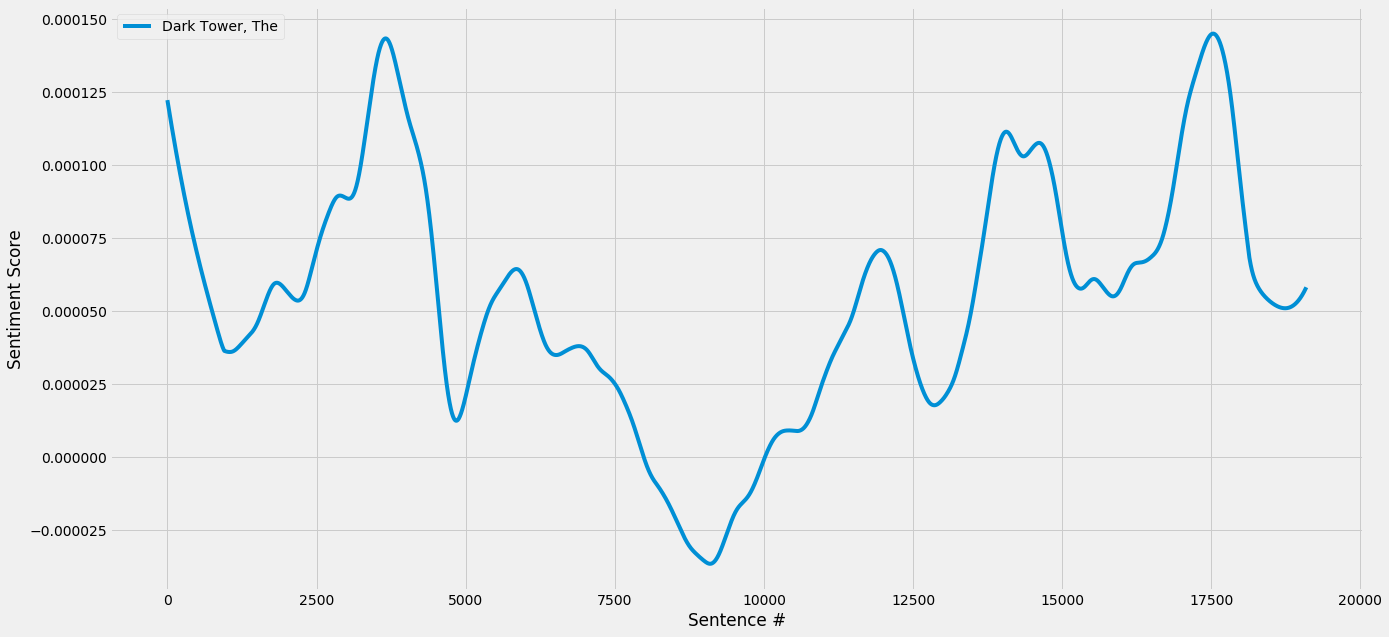

In [79]:
plot_story('Dark Tower, The',sentDF)

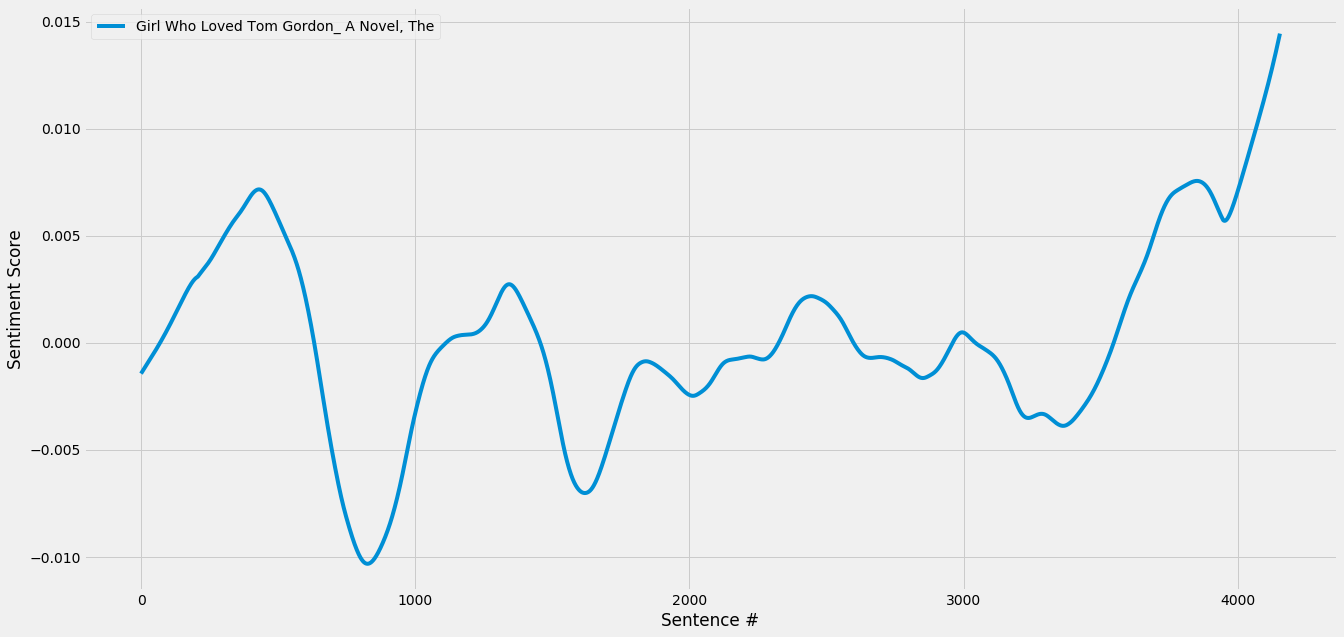

In [80]:
plot_story('Girl Who Loved Tom Gordon_ A Novel, The',sentDF)

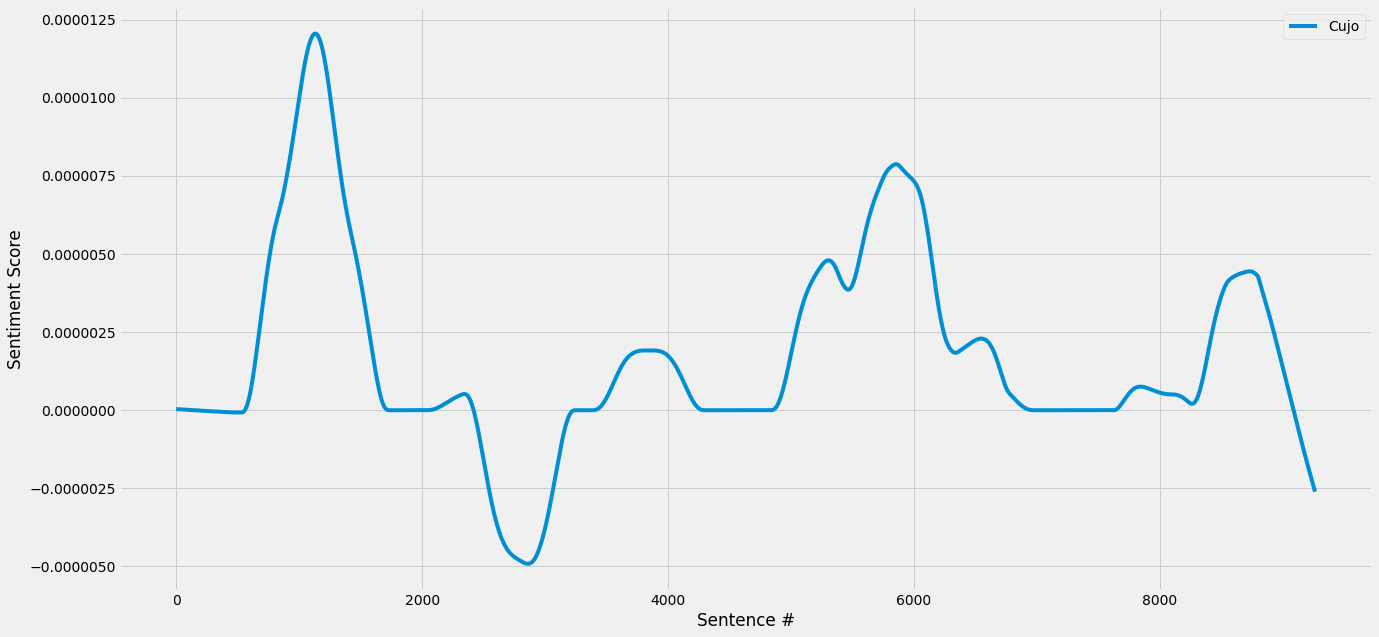

In [83]:
plot_story('Cujo',sentDF)

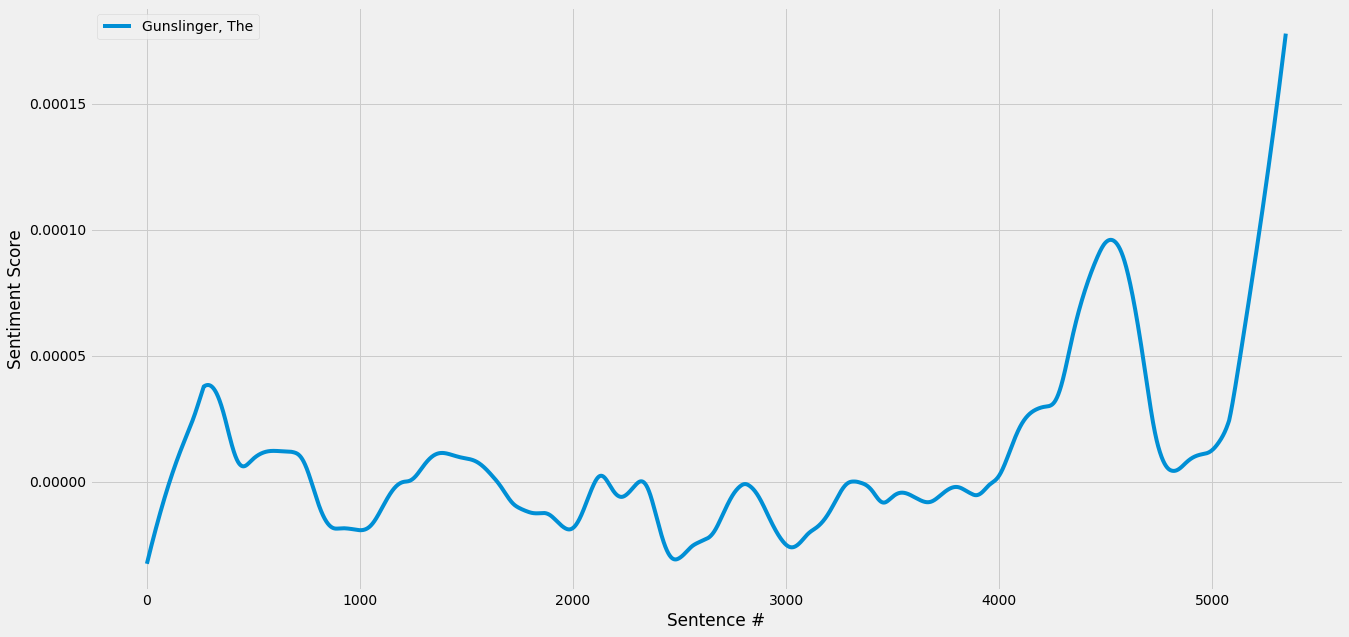

In [85]:
plot_story('Gunslinger, The')

In [ ]:
plot_story('Stand, The')

In [ ]:
plot_story('Wizard and Glass')

In [ ]:
plot_story('11_22_63')

In [ ]:
plot_story('Bag of Bones_ A Novel')

In [ ]:
plot_story('Shining, The')

### Novel Sentiment Average

In [19]:
sentGroup = sentDF.groupby(['title','year']).sentiment.mean().reset_index()
sentGroup.sort_values('sentiment',ascending=False,inplace=True)

In [89]:
year = sentDF.year

In [1]:
#sentGroup.merge(pd.DataFrame(data = [year.values] * len(year), columns = year.index),how=left, left_index=True, right_index=True)

In [20]:
sentGroup.head()

,title,year,sentiment
7,"Colorado Kid, The",2005,0.057708
35,Joyland,2013,0.057485
14,Doctor Sleep_ A Novel,2013,0.048100
48,Revival,2014,0.046053
2,Big Driver,2010,0.042320


## Bins

In [25]:
bins = [1974, 1985, 1995, 2005, 2015]

In [28]:
sentGroup['year'] = sentGroup.year.astype(int)

In [26]:
group_names = ['1975-1985', '1986-1995', '1996-2005', '2006-2015']

In [43]:
categories = pd.cut(sentGroup['year'], bins, labels=group_names)
sentGroup['categories'] = pd.cut(sentGroup['year'], bins, labels=group_names)
sentGroup['yearsBinned'] = pd.cut(sentGroup['year'], bins)
categories

7     1996-2005
35    2006-2015
14    2006-2015
48    2006-2015
2     2006-2015
0     2006-2015
65    2006-2015
67    1996-2005
21    2006-2015
51    1986-1995
49    1996-2005
42    2006-2015
15    1986-1995
25    2006-2015
10    1996-2005
28    2006-2015
56    1996-2005
37    2006-2015
1     1996-2005
62    2006-2015
66    1996-2005
50    1975-1985
36    2006-2015
43    1986-1995
20    2006-2015
11    1975-1985
63    2006-2015
13    1975-1985
24    1996-2005
31    1996-2005
        ...    
53    1975-1985
57    1975-1985
59    1975-1985
4     2006-2015
47    1996-2005
23    1986-1995
22    1975-1985
9     1986-1995
6     2006-2015
55    1975-1985
3     2006-2015
39    2006-2015
30    1975-1985
34    1975-1985
16    1996-2005
44    1975-1985
12    1996-2005
46    1975-1985
52    1975-1985
40    1986-1995
5           NaN
32    2006-2015
38    1975-1985
8     1975-1985
27    1996-2005
54    1975-1985
58    1975-1985
41    1975-1985
60    2006-2015
29    1996-2005
Name: year, Length: 68, 

In [51]:
sentGroup.categories.isnull().sum()

1

In [53]:
sentGroup.dropna(axis=0,inplace=True)

In [54]:
yearGroup = sentGroup.groupby('year').sentiment.mean().reset_index()


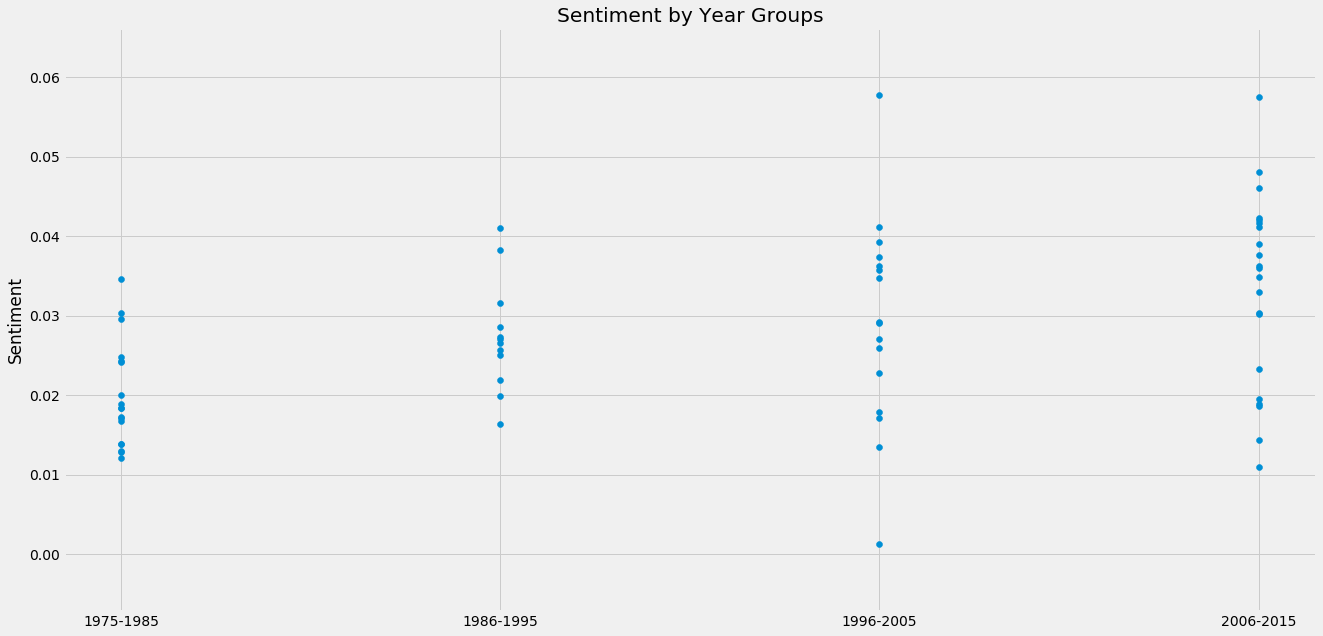

In [55]:
plt.scatter(sentGroup.categories,sentGroup.sentiment)
plt.title("Sentiment by Year Groups")
plt.ylabel('Sentiment')
plt.savefig('images/sent_years.svg')

## mpld3 Test

In [ ]:
mpld3.enable_notebook()

In [ ]:
def plot_d3(title,df=sentDF,f=.1,d=0.0):
    bookDF = df.loc[df['title'] == title]
    sentiment = list(bookDF.sentiment)
    lowX = list(range(1,len(sentiment)+1))
    #print(len(sent),len(lowX))
    low_plot = lowess(sentiment,lowX,frac=.1,return_sorted=False,delta=d)
    fig = plt.figure()
    plt.plot(low_plot,label=title)
    plt.ylabel("Sentiment Score")
    plt.xlabel("Sentence #")    
    plt.legend()
#     plt.savefig('images/'+title+'.svg')
    mpld3.show()
    p = mpld3.fig_to_d3(fig)
    return p

## Model Fits

### TFIDF Vectorizer

In [68]:
# tf = TfidfVectorizer(stop_words=stoplist,use_idf=True,max_df=.0018,token_pattern="\\b[a-z][a-z]+\\b")
# x2 = tf.fit_transform(books)
# tf_feature_names = tf.get_feature_names()

In [69]:
# x2.shape

(748650, 72700)

### Cosine Similarity

In [ ]:
# dist = 1 - cosine_similarity(x2)

### NMF

#### With TFIDF

In [70]:
# nmf2 = NMF(n_components=20, init='random')
# nmf_fit = nmf2.fit_transform(x2)

In [71]:
# no_top_words = 5
# no_top_documents = 2

In [72]:
# display_topics(nmf2,tf_feature_names,10)

Topic 0:
shouted beverly steve ear grabbed surprise todd rusty al sadie
Topic 1:
thad stark liz beaumont rawlie write pangborn wendy grinned muttered
Topic 2:
christ sake holy almighty steve muttered wish hurry sweet garraty
Topic 3:
important garraty letter speak write meeting knowing carefully forgotten surely
Topic 4:
callahan shrugged pere church cross sighed oy agreed calla grinned
Topic 5:
blaze huh uh shrugged sir grinned forgot stared luck bathroom
Topic 6:
sick stomach makes dying garraty gets doctor weak pale person
Topic 7:
crying harder beautiful rachel makes helen leaned duddits nearly gulls
Topic 8:
brian sir gaunt rusk glanced albert agreed lippy sean card
Topic 9:
problem drinking steve solve serious simple solved replied solving seconds
Topic 10:
glad safe sir damned rid bastard mort sight questions garraty
Topic 11:
thanks sir welcome sam lloyd harold rosie calling ride pass
Topic 12:
larry harold shrugged underwood nadine lucy glen met fran softly
Topic 13:
dear swee

In [73]:
# topics = return_topics(nmf2,tf_feature_names,10)

Topic 0:
shouted beverly steve ear grabbed surprise todd rusty al sadie
Topic 1:
thad stark liz beaumont rawlie write pangborn wendy grinned muttered
Topic 2:
christ sake holy almighty steve muttered wish hurry sweet garraty
Topic 3:
important garraty letter speak write meeting knowing carefully forgotten surely
Topic 4:
callahan shrugged pere church cross sighed oy agreed calla grinned
Topic 5:
blaze huh uh shrugged sir grinned forgot stared luck bathroom
Topic 6:
sick stomach makes dying garraty gets doctor weak pale person
Topic 7:
crying harder beautiful rachel makes helen leaned duddits nearly gulls
Topic 8:
brian sir gaunt rusk glanced albert agreed lippy sean card
Topic 9:
problem drinking steve solve serious simple solved replied solving seconds
Topic 10:
glad safe sir damned rid bastard mort sight questions garraty
Topic 11:
thanks sir welcome sam lloyd harold rosie calling ride pass
Topic 12:
larry harold shrugged underwood nadine lucy glen met fran softly
Topic 13:
dear swee

In [74]:
# topicsDF = pd.DataFrame(topics)

In [75]:
# topicsDF.head()

,topic_idx,words
0,0,shouted beverly steve ear grabbed surprise tod...
1,1,thad stark liz beaumont rawlie write pangborn ...
2,2,christ sake holy almighty steve muttered wish ...
3,3,important garraty letter speak write meeting k...
4,4,callahan shrugged pere church cross sighed oy ...


## Rejoin to Original DF

In [76]:
# sentDF.columns

Index(['isbn', 'title', 'year', 'content'], dtype='object')

In [77]:
# np.mean(nmf_fit[sentDF['title'] == 'Cujo'], axis=0)

array([ 0.00033177,  0.00019443,  0.00078174,  0.00049147,  0.00016345,
        0.00023781,  0.00075588,  0.00035424,  0.00015663,  0.0005245 ,
        0.00026624,  0.00023299,  0.00011855,  0.00029583,  0.00329023,
        0.00032916,  0.0003343 ,  0.00032695,  0.00045089,  0.00076047])

In [78]:
# unique_titles = list(set(titles))

In [79]:
# topic_list = []
# for title in unique_titles:
#     topic_mean = np.mean(nmf_fit[sentDF['title'] == title], axis=0)
#     #print(max(topic_mean))
#     itemindex = np.where(topic_mean==max(topic_mean))
#     #itemindex = topic_mean.argsort()[-3:][::-1]
#     #print (int(itemindex[0]))
#     topic_title = {"title":title,"topic_category":int(itemindex[0])}
#     topic_list.append(topic_title)
    

In [80]:
# topics_df = pd.DataFrame(topic_list)

In [ ]:
# topics_df.head(30)

In [82]:
topicGroup = topics_df.groupby('topic_category').title.count().reset_index()
topicGroup.sort_values('title',ascending=False, inplace=True)

In [83]:
topicGroup

,topic_category,title
6,14,59
2,4,2
4,8,2
0,0,1
1,1,1
3,5,1
5,12,1
7,18,1


In [84]:
#joblib.dump(nmf2, 'nmf_tdidf.pkl')

In [85]:
#nmf_pickle = joblib.load('nmf_tdidf.pkl')

In [ ]:
from sklearn.manifold import TSNE

tsne_model = TSNE(n_components=2, random_state=0)
results = tsne_model.fit_transform(nmf_fit) 

def get_coords(matrix2D):
    x = []
    y = []
    for r in matrix2D:
        x.append(r[0])
        y.append(r[1])
    return x, y

x, y = get_coords(results)

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=15, random_state=0).fit(nmf_fit)

# Scatter plot with colouring by kmeans labels:
plt.scatter(x, y, c=kmeans.labels_, marker='o', s=30);

In [ ]:
clusters = kmeans.clusters.tolist()

## Clustering

In [ ]:
# lda2.print_topics()

In [ ]:
# print(stoplist)

### K-Means

In [181]:
km2 = KMeans(n_clusters=8,init='k-means++')

km2.fit(x2)

clusters = km2.labels_.tolist()

In [182]:
clusters = km2.labels_.tolist()

In [183]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

ValueError: Shape of passed values is (2, 68), indices imply (2, 748650)

In [ ]:
frame.cluster.value_counts()

In [185]:
km3 = KMeans(n_clusters=8)

km3.fit(fit2)

clusters = km3.labels_.tolist()

In [186]:
clusters = km3.labels_.tolist()

In [187]:
test_dict = { 'title': title_list, 'content': book_list, 'cluster': clusters}

frame = pd.DataFrame(test_dict, index = [clusters] , columns = ['title', 'cluster'])

In [188]:
frame.cluster.value_counts()

1    45
7     7
6     4
5     4
2     3
4     2
0     2
3     1
Name: cluster, dtype: int64

## Aggregate Sentiment

## Scrap

Test Splitting the text for just the story content

In [95]:
# start = gs_text.find('******start_of_file******')+25
# end = gs_text.find('******end_of_file******')
# gs_text = gs_text[start:end]

In [105]:
# gs_text[-20:-1]

'ble final battle.\n\n'

In [36]:
# words = [''.join(words) for words in gs_text.split()]

In [52]:
counter = Counter()
n = 1
words = [w for w in words if w not in stoplist]
bigrams = ngrams(words, n)
counter += Counter(bigrams)

sorted_counter = sorted(counter.items(), key=operator.itemgetter(1),reverse=True)
# for word, count in gBlob.word_counts.items():
#     print("%15s %i" % (word, count))

In [53]:
sorted_counter

[(('gunslinger',), 531),
 (('man',), 243),
 (('boy',), 236),
 (('one',), 218),
 (('like',), 201),
 (('would',), 186),
 (('“i',), 169),
 (('black',), 156),
 (('said.',), 151),
 (('looked',), 147),
 (('back',), 143),
 (('could',), 136),
 (('said',), 129),
 (('jake',), 120),
 (('made',), 103),
 (('don’t',), 99),
 (('even',), 92),
 (('him.',), 92),
 (('it.',), 90),
 (('him,',), 89),
 (('eyes',), 88),
 (('seemed',), 87),
 (('came',), 85),
 (('roland',), 85),
 (('face',), 83),
 (('went',), 82),
 (('felt',), 81),
 (('might',), 80),
 (('way',), 77),
 (('still',), 77),
 (('know',), 76),
 (('time',), 75),
 (('never',), 74),
 (('come',), 74),
 (('“you',), 73),
 (('see',), 71),
 (('first',), 69),
 (('two',), 69),
 (('thought',), 68),
 (('cort',), 68),
 (('began',), 66),
 (('hands',), 66),
 (('said,',), 66),
 (('long',), 65),
 (('it,',), 65),
 (('last',), 65),
 (('go',), 64),
 (('almost',), 63),
 (('head',), 60),
 (('didn’t',), 59),
 (('saw',), 59),
 (('perhaps',), 59),
 (('old',), 58),
 (('three',

In [70]:
all_books = db.books.find({})

In [7]:
# df = pd.DataFrame(columns=['title','isbn','text'])
# for book in all_books:
#     df2 = 

In [8]:
# book_counts = {}
# for book in all_books:
#     title,counts = book_word_count(book,1)
#     book_counts[title] = counts

In [9]:
# clean_books = []
# for book in all_books:
#     text = clean_text(book)
#     clean_books.append(text)

In [10]:
# book_list = sorted(book_list)

In [11]:
dt_books = ['Gunslinger, The','Drawing of the Three, The','Waste Lands, The',
            'Wizard and Glass','Wolves of the Calla','Song of Susannah','Dark Tower, The']

In [30]:
print(dt_books)

['Gunslinger, The', 'Drawing of the Three, The', 'Waste Lands, The', 'Wizard and Glass', 'Wolves of the Calla', 'Song of Susannah', 'Dark Tower, The']


In [12]:
# all_books = db.books.find({})

In [13]:
# all_text = []
# for book in all_books:
#     text = clean_text(book)
#     all_text.append(text)

In [5]:
# dt_text = []
# for book in all_books:
#     if book['title'] in dt_books:
#         text  = clean_text(book)
#         name = book['title']
#         print(book['title'])
#         dt_text.append(text)
#     #else:
#         #print("Haha Fuck you!")

In [64]:
len(dt_text)

7

In [69]:
df,corp,id2word = book_cv(dt_text,stoplist)

<class 'str'>
(29598, 7)


In [ ]:
df.shape